In [1]:
pip install vk_api

Note: you may need to restart the kernel to use updated packages.


In [464]:
import vk_api
import json
import re
import networkx as nx
import matplotlib.pyplot as plt

In [465]:
vk_session = vk_api.VkApi('gg', 'gg')
vk_session.auth()

vk = vk_session.get_api()

In [466]:
# Это класс, который достает информацию о комментарии 
#(функция get_speaker возвращает имя комментатора
# функция get_whom возвращает имя комментируемого
# функция get_text возвращает текст комментария
# функция answer возвращает лист вида ["кто", "кому"] для построения графа)
# функция get_last_id возвращает id пользователя, чей комментарий был только что обработан

# Теперь всё не совсем так

class Comment:
    
    def calc_whom(raw):
        text    = raw.get('text')
        pattern = re.compile('\[id\d+\|\w+\]')
        whom    = pattern.findall(text)
        res     = []
        for whom_person in whom:
            pattern_id = re.compile('\[id\d+\|')
            whom_id = pattern_id.findall(whom_person)
            whom_id = whom_id[0].strip(']').strip('[').strip('|').replace('id', '')
            res.append(int(whom_id))
        return res
    
    def __init__(self, i):
        self.i      = i
        self.author = i['from_id']
        self.text   = i['text']
        self.whom   = Comment.calc_whom(i)
        self.id     = i['id']
        self.time   = i['date']
        
        self.reply = None
        if 'reply_to_comment' in i:
            self.reply = i['reply_to_comment']
        
        self.stack = 0
        if 'parents_stack' in self.i and len(self.i['parents_stack']) > 0:
            self.stack = self.i['parents_stack'][0]
        else:
            self.stack = self.i['id']
    
    def set_reply(self, reply):
        self.reply = reply
        
    def get_stack(self):
        return self.stack
    
    def get_from(self):
        return self.author
    
    def get_whom(self):
        return self.whom
        
    def get_text(self):
        return self.text
    
    def get_raw(self):
        return self.i
    
    def get_time(self):
        return self.time
    
    def get_reply(self):
        return self.reply
    
    def get_id(self):
        return self.id
    

In [467]:
def get_wall(domain, count):
    wall = vk.wall.get(domain = domain, count = count).get('items')
    return wall

In [468]:
def get_comment_subcomments(post_id, owner_id, comment_id, subcomments_depth):
    print("parsing subcomments")
    comments = vk.wall.getComments(post_id = post_id, owner_id = owner_id, comment_id = comment_id, 
                                   count = subcomments_depth, v = '5.91', extended=1, fields='id').get('items')
    print(len(comments))
    return comments

# функция парсит комменты из поста. Можно вызывать сразу её, минуя get_wall

In [469]:
def parse_post(post_id, owner_id, comments_depth, subcomments_depth):
    res = []
    comments = get_comments_list(id, owner_id, comments_depth, subcomments_depth)
    for comment in comments:
        res.append(Comment(comment))
    return res

In [470]:
def get_comments_list(post_id, owner_id, comments_depth, subcomments_depth):
    print("parsing comments")
    comments = vk.wall.getComments(post_id = post_id, owner_id = owner_id, count = comments_depth, v = '5.91',
                                  extended=1, fields='id').get('items')
    result = []
    for comment in comments:
        result.append(comment)
        subcomments = get_comment_subcomments(post_id, owner_id, comment['id'], subcomments_depth)
        for subcomment in subcomments:
            result.append(subcomment)
    print("Commets + sub: ", len(result))
    return result

In [471]:
def parse_wall(domain, wall_depth, comments_depth, subcomments_depth):
    wall = get_wall(domain, wall_depth)
    res = []
    for post in wall:
        id       = post['id']
        owner_id = post['owner_id']
        comments = get_comments_list(id, owner_id, comments_depth, subcomments_depth)
        for comment in comments:
            res.append(Comment(comment))
    return res

In [472]:
comments = parse_wall('lentach', 1, 100, 100)

parsing comments
parsing subcomments
6
parsing subcomments
0
parsing subcomments
1
parsing subcomments
0
parsing subcomments
2
parsing subcomments
1
parsing subcomments
0
parsing subcomments
8
parsing subcomments
0
parsing subcomments
0
parsing subcomments
1
parsing subcomments
0
Commets + sub:  31


In [473]:
def find_closest_comment(comments, stack, users, stop_id):
    commets_from_user_before_time               = []
    commets_from_user_before_time_in_same_stack = []
    commets_before_time_in_same_stack           = []

#     print('stack, ', stack)
#     print('users, ', users)
#     print('stop_id, ',  stop_id)

    for comment in comments:
        if comment.get_id() == stop_id:
            break
        if comment.get_from() in users:
            if (comment.get_stack == stack):
                commets_from_user_before_time_in_same_stack.append(comment.get_id())
            commets_from_user_before_time.append(comment.get_id())
        if comment.get_stack() == stack:
            commets_before_time_in_same_stack.append(comment.get_id())
#     print(commets_from_user_before_time_in_same_stack)
#     print(commets_before_time_in_same_stack)
#     print(commets_from_user_before_time)
    if len(commets_from_user_before_time_in_same_stack) > 0:
        return commets_from_user_before_time_in_same_stack[-1]
    if len(commets_from_user_before_time) > 0:
        return commets_from_user_before_time[-1]
    if len(commets_before_time_in_same_stack) > 0:
        return commets_before_time_in_same_stack[0]
    return 0

In [474]:
def fix_replies(comments):
    for comment in comments:
        if comment.get_reply() == None:
#             print('call *******************************************')
#             print('text:', comment.get_text())
            prognosed_reply = find_closest_comment(comments, comment.get_stack(), comment.get_whom(), comment.get_id())
#             print('res: ', prognosed_reply)
            comment.set_reply(prognosed_reply)
            

In [475]:
fix_replies(comments)

In [476]:
for comment in comments:
    print('=== raw ===')
    print(comment.get_raw())
    print('***********')
    print('from :', comment.get_from())
    print('whom :', comment.get_whom())
    print('text :', comment.get_text())
    print('stack:', comment.get_stack())
    print('time :', comment.get_time())
    print('reply:', comment.get_reply())

=== raw ===
{'id': 12466961, 'from_id': 153889821, 'post_id': 12466955, 'owner_id': -29534144, 'parents_stack': [], 'date': 1575409553, 'text': 'Мрачная музыка, как и его цвет кожи) 0', 'thread': {'count': 6, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}}
***********
from : 153889821
whom : []
text : Мрачная музыка, как и его цвет кожи) 0
stack: 12466961
time : 1575409553
reply: 0
=== raw ===
{'id': 12466968, 'from_id': 531243448, 'post_id': 12466955, 'owner_id': -29534144, 'parents_stack': [12466961], 'date': 1575409612, 'text': '[id153889821|Александр],  как и твоя фамилия )))'}
***********
from : 531243448
whom : [153889821]
text : [id153889821|Александр],  как и твоя фамилия )))
stack: 12466961
time : 1575409612
reply: 12466961
=== raw ===
{'id': 12466969, 'from_id': -178127206, 'post_id': 12466955, 'owner_id': -29534144, 'parents_stack': [12466961], 'date': 1575409626, 'text': '[id153889821|Александр],', 'attachments': [{'type': 'photo', 'photo

In [477]:
def comments_to_graph(comments):
    G = nx.Graph()
    G.add_node(0)
    for comment in comments:
#         print('add node', comment.get_id())
        G.add_node(comment.get_id())
    for comment in comments:
#         print('add edge', comment.get_reply(), '->', comment.get_id())
        G.add_edge(comment.get_reply(), comment.get_id())
    return G

In [478]:
def draw_graph(G):
    nx.draw(G, with_labels=True)
    plt.show()

In [479]:
graph = comments_to_graph(comments)

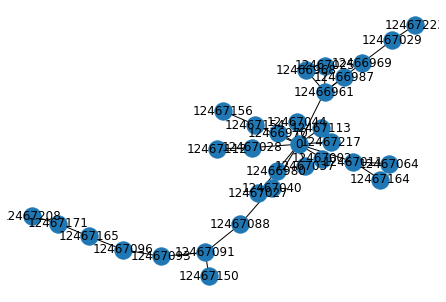

In [480]:
draw_graph(graph)

In [481]:
def get_talks_ends_list(comments):
    res = []
    for comment in comments:
        is_end_comment = True
        id = comment.get_id()
        for another_comment in comments:
            another_reply = another_comment.get_reply()
            if another_reply == id:
                is_end_comment = False
        if is_end_comment:
            res.append(comment.id)
    return res

In [482]:
talks_ends = get_talks_ends_list(comments)

In [483]:
def find_all_talks(G, talks_ends):
    res = []
    for end in talks_ends:
        res.append(nx.shortest_path(G, source=0, target=end)[1:])
    return sorted(res, key=len, reverse=True)

In [484]:
talks_ids = find_all_talks(graph, talks_ends)

In [485]:
for talk in talks_ids:
    print(talk)

[12467040, 12467088, 12467091, 12467093, 12467096, 12467165, 12467171, 12467208]
[12466961, 12466969, 12467029, 12467223]
[12467040, 12467088, 12467091, 12467150]
[12466961, 12466968]
[12466961, 12466987]
[12466961, 12467025]
[12466980, 12467027]
[12467011, 12467064]
[12467011, 12467164]
[12467028, 12467112]
[12467154, 12467156]
[12466970]
[12467002]
[12467037]
[12467044]
[12467113]
[12467217]


In [486]:
def find_comment_text_by_id(id, comments):
    for comment in comments:
        if comment.get_id() == id:
            return [str(comment.get_from()), comment.get_text()]
    return ['', '']

In [487]:
def create_conversations(talks_ids, comments):
    padding = ' ' * 13
    words_per_line = 10
    res = []
    for talk in talks_ids:
        conv = ''
        for msg_id in talk:
            author_text = find_comment_text_by_id(msg_id, comments)
            author = author_text[0]
            text   = author_text[1]
            
            splitted_by_words = text.split()
            splitted_by_lines = []
            i = 0
            curr_line = ''
            for word in splitted_by_words:
                curr_line += word + ' '
                i += 1
                if i == words_per_line:
                    splitted_by_lines.append(curr_line)
                    curr_line = ''
                    i = 0
            splitted_by_lines.append(curr_line)
            
            conv += '[' + author + ']: '
            for line in splitted_by_lines:
                conv += line + '\n' + padding
            conv += padding + '\n'
        res.append(conv)
    return res

In [488]:
conversations = create_conversations(talks_ids, comments)

In [489]:
for conv in conversations:
    print('***************************************************')
    print(conv)

***************************************************
[265421074]: Интересно, а может у американцев тоже есть свой лентач, куда 
             они выкладывают русских удивительных неизвестных исполнителей? 
                          
[318703046]: [id265421074|Ирина], Сомневаюсь. В России легко можно быть неизвестным, а вот 
             удивительным нет. 
                          
[265421074]: [id318703046|Виталий], удивительным для России нет или для запада? Раз на 
             раз не приходится 
                          
[318703046]: [id265421074|Ирина], Да. 
                          
[265421074]: [id318703046|Виталий], нет. 
                          
[107117263]: [id265421074|Ирина], учитывая что наша музыкальная индустрия это копирование, подражание, догоняние 
             и переосмысливание того что пришло с америки - большая часть 
             музыкальных субкультур зародилась там и пришла оттуда то какой бы 
             в этом был смысл? У них есть оригинал, а не 
         

In [ ]:
# создает и записывает в табличку output.xlsx данные 
d = {'имя коментатора': list_speakers, 'текст комментария': list_texts, 'имя комментируемого': list_whom}
df = pd.DataFrame(data=d)
## df.to_excel("output.xlsx")

In [ ]:
df